In [1]:
# %%capture cap
!pip install ipywidgets
!pip install autogluon scikit-learn==1.5.2 
!apt-get install -y graphviz graphviz-dev && pip install pydot
!pip install pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versi

In [2]:
import torch
import os
import pydot

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from time import time, sleep
from itertools import combinations

from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
# plt.style.use("ggplot")
# sns.set_style("whitegrid")

## -- Ansi color codes --
COLOR = '\033[32m'
RESET = '\033[0m'

In [3]:
### Load Data ###
PATH = "/kaggle/input/playground-series-s5e11/"
submit = pd.read_csv(PATH+"sample_submission.csv")

TARGET = "loan_paid_back"
train = pd.read_csv(PATH+"train.csv").drop(['id', TARGET], axis=1)
test = pd.read_csv(PATH+"test.csv").drop(['id'], axis=1)

NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
BASE = NUMS + CATS

ORIG_PATH = "/kaggle/input/loan-prediction-dataset-2025/"
orig = pd.read_csv(ORIG_PATH+"loan_dataset_20000.csv")[BASE+[TARGET]]

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (593994, 11)
Test shape: (254569, 11)
Original shape: (20000, 12)

Total Numerical: 5
Total Categorical: 6
Total base features: 11


In [4]:
display(orig.head())
orig.info()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,24240.19,0.074,743,17173.72,13.39,Male,Married,Master's,Employed,Car,B5,1
1,20172.98,0.219,531,22663.89,17.81,Female,Married,Bachelor's,Employed,Debt consolidation,F1,1
2,26181.80,0.234,779,3631.36,9.53,Female,Single,High School,Employed,Business,B4,1
3,11873.84,0.264,809,14939.23,7.99,Female,Single,High School,Employed,Other,A5,1
4,25326.44,0.260,663,16551.71,15.20,Other,Single,Other,Employed,Car,D5,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   annual_income         20000 non-null  float64
 1   debt_to_income_ratio  20000 non-null  float64
 2   credit_score          20000 non-null  int64  
 3   loan_amount           20000 non-null  float64
 4   interest_rate         20000 non-null  float64
 5   gender                20000 non-null  object 
 6   marital_status        20000 non-null  object 
 7   education_level       20000 non-null  object 
 8   employment_status     20000 non-null  object 
 9   loan_purpose          20000 non-null  object 
 10  grade_subgrade        20000 non-null  object 
 11  loan_paid_back        20000 non-null  int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 1.8+ MB


In [5]:
# def plot_heatmap(data, cat_features: list, title: str):
#     df = data.copy()
#     for c in cat_features:
#         df[c] = df[c].factorize()[0]
#     plt.figure(figsize=(18, 7))
#     sns.heatmap(df.corr('spearman'), mask=np.triu(df.corr('spearman')), annot=True)
#     plt.title(title, size=15, fontweight='semibold')
#     plt.tight_layout()
#     plt.show()

# plot_heatmap(train, CATS, "Train data")
# plot_heatmap(orig, CATS, "Original data")
# plot_heatmap(test, CATS, "Test data")

In [6]:
# CATS2 = []
# print(f"Categorization... ", end="")
# for c in FEATURES:
#     print(f"{c}, ", end="")
#     n = f"cat_{c}"
#     train[n] = train[c].astype('category')
#     cat = train[n].cat
#     test[n] = pd.Categorical(test[c], categories=cat.categories)
#     CATS2.append(n)

# print()
# display(train.head())
# train.info()

In [7]:
# ## -- Factorize using combined data --
# print(f"Label encoding... ", end="")
# for c in CATS:
#     print(f"{c}, ", end="")
#     combined = pd.concat([train[c], test[c], orig[c]], ignore_index=True)
#     combined = combined.factorize()[0]
#     train[c] = combined[:len(train)]
#     test[c]  = combined[len(train):len(train)+len(test)]
#     orig[c]  = combined[-len(orig):]

In [8]:
train.shape, test.shape

((593994, 11), (254569, 11))

In [9]:
display(train.head())
# train.info()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1


In [10]:
display(test.head())
# test.info()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5
1,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1
2,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1
3,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3
4,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1


In [11]:
# !rm -r /kaggle/working/AG_accident_models

In [12]:
from autogluon.tabular import TabularPredictor

In [13]:
## -- RUN 1: Use train data -- 
PATH = "./AG_loan_models"
PRESET = "best"

predictor = TabularPredictor(
                label = TARGET,
         problem_type = "binary",
          eval_metric = "roc_auc",
                 path = PATH,
    ).fit(
                   train_data = orig,
                      presets = PRESET,
                   time_limit = 3600*2,
                # num_bag_folds = 8,
             # dynamic_stacking = False,
                   # auto_stack = False,
             # num_stack_levels = 1,
                 # num_bag_sets = 2,
                  # ag_args_fit = {'num_cpus': os.cpu_count() - 1},
) 

Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Sep 27 10:16:09 UTC 2025
CPU Count:          4
Memory Avail:       29.95 GB / 31.35 GB (95.5%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon w

(_ray_fit pid=4398) [1000]	valid_set's binary_logloss: 0.270462
(_ray_fit pid=4538) [1000]	valid_set's binary_logloss: 0.265291 [repeated 6x across cluster]


(_dystack pid=412) 	0.89	 = Validation score   (roc_auc)
(_dystack pid=412) 	27.58s	 = Training   runtime
(_dystack pid=412) 	5.8s	 = Validation runtime
(_dystack pid=412) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 218.07s of the 816.54s of remaining time.
(_dystack pid=412) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_ray_fit pid=4685) 	Ran out of time, stopping training early. (Stopping on epoch 48)
(_ray_fit pid=4835) 	Ran out of time, stopping training early. (Stopping on epoch 40) [repeated 3x across cluster]
(_ray_fit pid=4871) 	Ran out of time, stopping training early. (Stopping on epoch 42)
(_ray_fit pid=4872) 	Ran out of time, stopping training early. (Stopping on epoch 42)
(_dystack pid=412) 	0.8938	 = Validation score   (roc_auc)
(_dystack pid=412) 	185.97s	 = Training   runtime
(_dystack pid=412) 	0.61s	 = Validation runtime
(_dystack pid=412) Fitting model: 

In [14]:
## -- Get Summary -- 
print(f"-> Total models : {len(predictor.model_names())}")
print(f"-> Best model   : {predictor.model_best}") 

## -- Observe RUN 1 RESULTS -- 
leaderboard = predictor.leaderboard(silent=True)
leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral")

-> Total models : 71
-> Best model   : WeightedEnsemble_L3


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.899721,roc_auc,40.559055,3664.006907,0.003699,3.892925,3,True,71
1,WeightedEnsemble_L2,0.899245,roc_auc,7.201663,808.065069,0.003695,3.847247,2,True,46
2,CatBoost_r13_BAG_L2,0.898670,roc_auc,34.635050,2928.429720,0.129811,145.184616,2,True,69
3,CatBoost_BAG_L2,0.898642,roc_auc,34.724351,2865.225641,0.219113,81.980536,2,True,51
4,CatBoost_r137_BAG_L2,0.898333,roc_auc,34.623854,2834.431044,0.118616,51.185940,2,True,67
5,CatBoost_r9_BAG_L2,0.898185,roc_auc,34.716738,2958.908571,0.211500,175.663466,2,True,62
6,CatBoost_r177_BAG_L2,0.898149,roc_auc,34.637014,2825.802234,0.131776,42.557130,2,True,58
7,NeuralNetFastAI_r143_BAG_L1,0.897930,roc_auc,0.444385,78.874744,0.444385,78.874744,1,True,39
8,NeuralNetFastAI_r145_BAG_L1,0.897053,roc_auc,1.502612,238.791562,1.502612,238.791562,1,True,26
9,NeuralNetFastAI_r191_BAG_L2,0.896572,roc_auc,35.743555,3045.334650,1.238317,262.089545,2,True,61


In [15]:
## -- RUN 2: Use original data as extra learning input --
# predictor.fit_pseudolabel(
#                 orig,
#                 use_ensemble = True,
#                 fit_ensemble = True,
#                 time_limit   = 3600*5,
#                 ag_args_fit  = {'num_cpus': os.cpu_count() - 1},
# )

In [16]:
## -- Get Summary -- 
# print(f"""
#     # {'█'*5}| Total models : {len(predictor.model_names())}
#     # {'█'*5}| Best model   : {predictor.model_best}
#         """)

# # -- Observe RUN 2 RESULTS --
# leaderboard = predictor.leaderboard(silent=True)
# display(leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral"))

In [17]:
## -- Create folder directory to save predictions --
# NAME_EXT = "_orig_baseCPU"
# FOLDER   = "AG_loan_predictions"
# !mkdir /kaggle/working/{FOLDER}{NAME_EXT}

In [18]:
%%time
n = f'origY_{PRESET}'
orig_oof = predictor.predict_proba_oof(as_multiclass=False).rename(n)
orig_oof.to_csv(n +'.csv', index=False)
print(f"✅ {n} file saved")
orig_oof

✅ origY_best file saved
CPU times: user 33.7 ms, sys: 3.01 ms, total: 36.7 ms
Wall time: 44.9 ms


0        0.999253
1        0.761134
2        0.949516
3        0.958824
4        0.767436
           ...   
19995    0.782104
19996    0.838546
19997    0.996084
19998    0.984162
19999    0.801831
Name: origY_best, Length: 20000, dtype: float32

In [19]:
%%time
save_data = dict(trainY_=train, testY_=test)
for k, v in save_data.items():
    preds = predictor.predict_proba(v, as_multiclass=False).rename(f"{k}{PRESET}")
    preds.to_csv(f"{k}{PRESET}.csv", index=False)
    print(f"✅ {k}{PRESET}.csv file saved") 

✅ trainY_best.csv file saved
✅ testY_best.csv file saved
CPU times: user 2h 13min 35s, sys: 36.2 s, total: 2h 14min 11s
Wall time: 1h 5min 3s


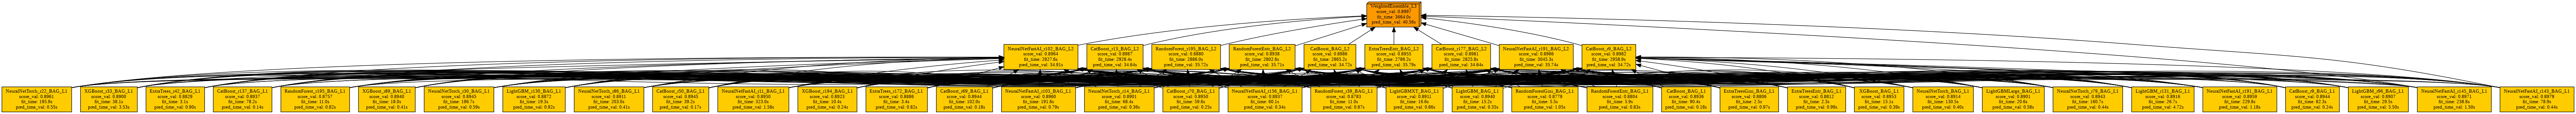

In [20]:
predictor.plot_ensemble_model(filename='ensemble_model.png')
display(Image('./AG_loan_models/ensemble_model.png'))

In [21]:
# !zip -r /kaggle/working/AG_accident_models /kaggle/working/AG_accident_models.zip
!zip -r {FOLDER}{NAME_EXT}.zip /kaggle/working/{FOLDER}{NAME_EXT}

	zip warning: name not matched: /kaggle/working/{FOLDER}{NAME_EXT}

zip error: Nothing to do! (try: zip -r {FOLDER}{NAME_EXT}.zip . -i /kaggle/working/{FOLDER}{NAME_EXT})


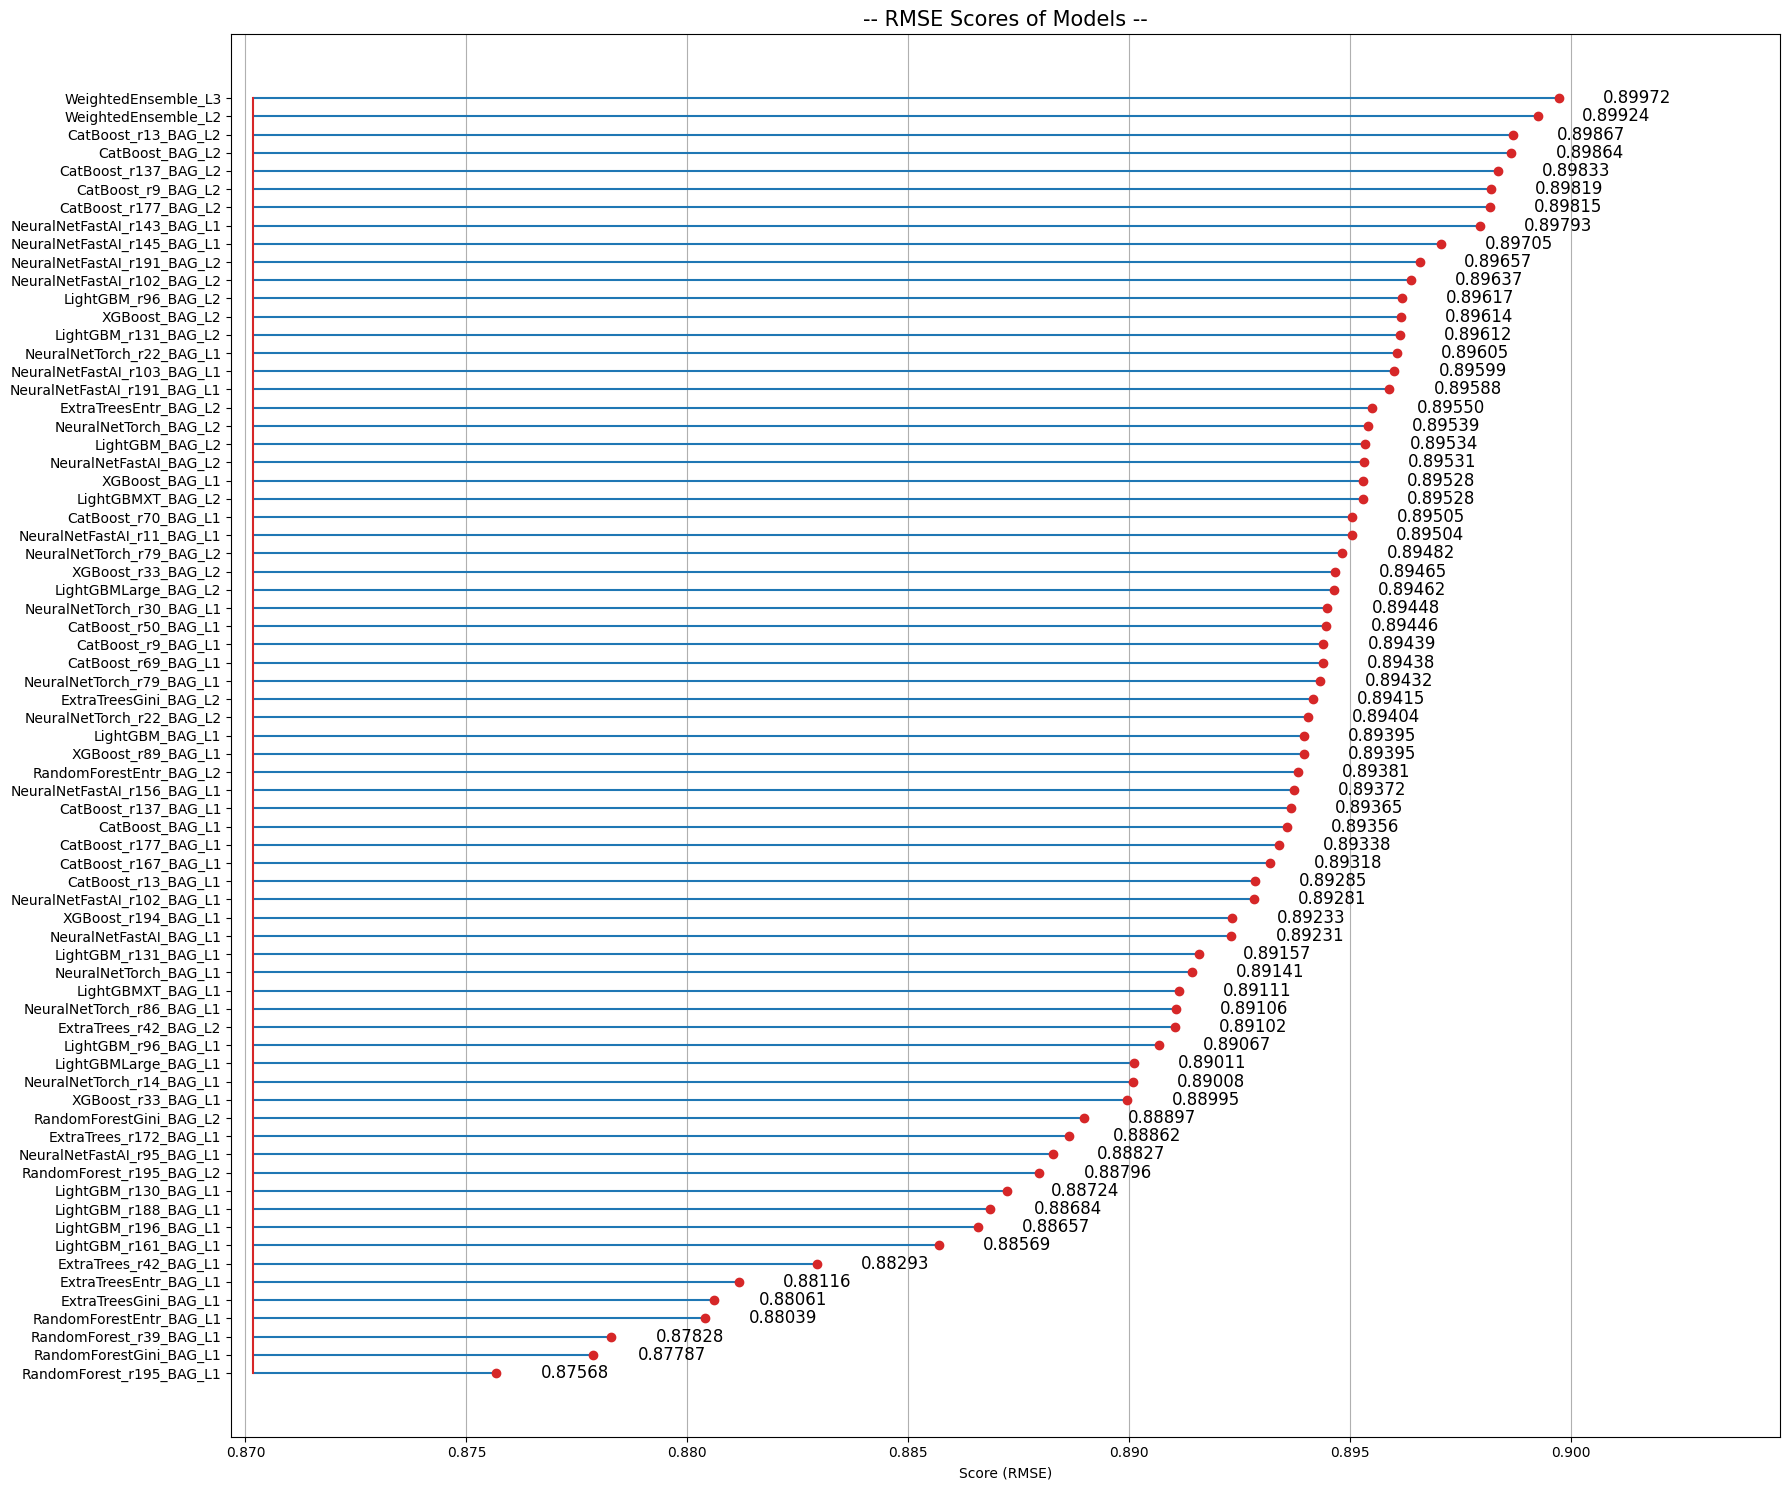

In [22]:
## -- Extract model scores --
result_ = dict(zip(leaderboard['model'], leaderboard['score_val']))
result_df = pd.DataFrame.from_dict(result_, orient='index').sort_values(0)

max_score = result_df.max().item()
min_score = result_df.min().item()

## -- PLOT MODELS & SCORES --
plt.figure(figsize=(18, 15))
plt.stem(
    result_df.index,
    result_df[0],
    orientation = 'horizontal',
    bottom = min_score - 0.0055,
    markerfmt = 'C3o'
)
plt.xlim(min_score - 0.006, max_score + 0.005)
plt.xlabel('Score (RMSE)')
plt.title('-- RMSE Scores of Models --', fontsize=15)

for i, value in enumerate(result_df[0]):
    plt.text(value+1e-3, i, f'{abs(value):.5f}', ha='left', va='center', fontdict=dict(size=12))

plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [23]:
# predictor.model_names()

In [24]:
# ## -- Permutation Feature Importances --
# feat_imp = predictor.feature_importance(
#                         data = X_test,
#                         # time_limit = 3600,
#                         # model = 'LightGBM_BAG_L1',
#                         # features = None,
#                         # feature_stage = 'transformed',
#                         # subsample_size = 5000,
#                         # num_shuffle_sets = 10,
#                         # include_confidence_band = True,
#                         confidence_level = 0.95,
#                         # silent = False
# ) 

# feat_imp.style.background_gradient(subset=["importance"], cmap="Spectral")

In [25]:
# plt.figure(figsize=(18, 35))
# sns.barplot(data=feat_imp, y=feat_imp.index, x=feat_imp.importance)
# plt.tick_params(axis='y', which='major', labelcolor='r')
# plt.title("Top Features by Permutation")
# plt.tight_layout()
# plt.show()

In [26]:
## -- OPTIONAL: Remove stored files --
!rm -r /kaggle/working/AG_loan_models
# !rm -r /kaggle/working/{FOLDER}{NAME_EXT}

In [27]:
print(f"""
{'-'*48}
{'█'*5} | - AUTOGLUON NOTEBOOK COMPLETE! - | {'█'*5}
{'-'*48}
""")


------------------------------------------------
█████ | - AUTOGLUON NOTEBOOK COMPLETE! - | █████
------------------------------------------------

